In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [73]:
df=pd.read_csv('/content/train.csv')

In [74]:
df.head()

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-1977,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [75]:
df.shape

(233154, 41)

In [76]:
df.columns

Index(['UNIQUEID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID',
       'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'DATE_OF_BIRTH',
       'EMPLOYMENT_TYPE', 'DISBURSAL_DATE', 'STATE_ID', 'EMPLOYEE_CODE_ID',
       'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG',
       'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE',
       'PERFORM_CNS_SCORE_DESCRIPTION', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
       'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT',
       'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
       'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT',
       'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT',
       'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
       'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES',
       'LOAN_DEFAULT'],
      dtype='object')

In [77]:
null=df.isnull().sum().sort_values(ascending=False)
total=df.shape[0]
percent_missing=(df.isnull().sum()/total).sort_values(ascending=False)
missing_data=pd.concat([null,percent_missing],axis=1,keys=['total_missing','percent_missing'])

In [78]:
missing_data.head()

,total_missing,percent_missing
EMPLOYMENT_TYPE,7661,0.032858
DISBURSED_AMOUNT,0,0.000000
ASSET_COST,0,0.000000
LTV,0,0.000000
BRANCH_ID,0,0.000000


In [79]:
#fill missing values
df['EMPLOYMENT_TYPE']=df['EMPLOYMENT_TYPE'].fillna('unknown')

In [80]:
#check if it is a imbalance dataset
print(df.groupby('LOAN_DEFAULT').count()['UNIQUEID'].reset_index())

   LOAN_DEFAULT  UNIQUEID
0             0    182543
1             1     50611


In [81]:
def convert_year_to_days(age_str):
  if pd.isnull(age_str):
    return None
  try:
    parts=age_str.lower().replace('yrs','').replace('mon','').split()
    years=int(parts[0])
    month=int(parts[1])
    days=years*365 + month*30
    return days
  except:
    return None

In [82]:
df['AVERAGE_ACCT_AGE']=df['AVERAGE_ACCT_AGE'].apply(convert_year_to_days)
df['CREDIT_HISTORY_LENGTH']=df['CREDIT_HISTORY_LENGTH'].apply(convert_year_to_days)

In [83]:
#convert categorial cols into numeric cols
#categorical columns
cat_cols=df.select_dtypes(include='object').columns
cat_df=df[cat_cols]

In [84]:
cat_df.head()

,DATE_OF_BIRTH,EMPLOYMENT_TYPE,DISBURSAL_DATE,PERFORM_CNS_SCORE_DESCRIPTION
0,01-01-1984,Salaried,03-08-2018,No Bureau History Available
1,31-07-1985,Self employed,26-09-2018,I-Medium Risk
2,24-08-1985,Self employed,01-08-2018,No Bureau History Available
3,30-12-1993,Self employed,26-10-2018,L-Very High Risk
4,09-12-1977,Self employed,26-09-2018,No Bureau History Available


In [85]:
cat_df['PERFORM_CNS_SCORE_DESCRIPTION'].unique()

array(['No Bureau History Available', 'I-Medium Risk', 'L-Very High Risk',
       'A-Very Low Risk',
       'Not Scored: Not Enough Info available on the customer',
       'D-Very Low Risk', 'M-Very High Risk', 'B-Very Low Risk',
       'C-Very Low Risk', 'E-Low Risk', 'H-Medium Risk', 'F-Low Risk',
       'K-High Risk',
       'Not Scored: No Activity seen on the customer (Inactive)',
       'Not Scored: Sufficient History Not Available',
       'Not Scored: No Updates available in last 36 months', 'G-Low Risk',
       'J-High Risk', 'Not Scored: Only a Guarantor',
       'Not Scored: More than 50 active Accounts found'], dtype=object)

In [86]:
risk_mapping = {
    'No Bureau History Available': 1,
    'I-Medium Risk': 2,
    'L-Very High Risk': 3,
    'A-Very Low Risk': 4,
    'Not Scored: Not Enough Info available on the customer': 5,
    'D-Very Low Risk': 6,
    'M-Very High Risk': 7,
    'B-Very Low Risk': 8,
    'C-Very Low Risk': 9,
    'E-Low Risk': 10,
    'H-Medium Risk': 11,
    'F-Low Risk': 12,
    'K-High Risk': 13,
    'Not Scored: No Activity seen on the customer (Inactive)' : 14,
    'Not Scored: Sufficient History Not Available' : 15,
    'Not Scored: No Updates available in last 36 months' : 16,
    'G-Low Risk' : 17,
    'J-High Risk' : 18,
    'Not Scored: Only a Guarantor' : 19,
    'Not Scored: More than 50 active Accounts found' : 20

}
df['PERFORM_CNS_SCORE_DESCRIPTION'] = df['PERFORM_CNS_SCORE_DESCRIPTION'].map(risk_mapping).fillna(0)

In [87]:
df['DATE_OF_BIRTH']=pd.to_datetime(df['DATE_OF_BIRTH'], format='%d-%m-%Y')
df['DISBURSAL_DATE']=pd.to_datetime(df['DISBURSAL_DATE'], format='%d-%m-%Y')

In [88]:
df['AGE_AT_DISBURSAL']=(df['DISBURSAL_DATE']-df['DATE_OF_BIRTH']).dt.days // 365

In [90]:
#one hot encode employment_type
df=pd.get_dummies(df,columns=['EMPLOYMENT_TYPE'],prefix='EMP',dtype=int)

In [91]:
#VIEW THE RESULT
print(df.filter(like='EMP_').head())

   EMP_Salaried  EMP_Self employed  EMP_unknown
0             1                  0            0
1             0                  1            0
2             0                  1            0
3             0                  1            0
4             0                  1            0


In [95]:
df.drop(['DATE_OF_BIRTH','DISBURSAL_DATE'],axis=1,inplace=True)

In [96]:
df.head()

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,STATE_ID,EMPLOYEE_CODE_ID,...,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT,AGE_AT_DISBURSAL,EMP_Salaried,EMP_Self employed,EMP_unknown
0,420825,50578,58400,89.55,67,22807,45,1441,6,1998,...,0,0,0,0,0,0,34,1,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,6,1998,...,0,1,695,695,0,1,33,0,1,0
2,417566,53278,61360,89.63,67,22807,45,1497,6,1998,...,0,0,0,0,0,0,32,0,1,0
3,624493,57513,66113,88.48,67,22807,45,1501,6,1998,...,0,0,240,455,1,1,24,0,1,0
4,539055,52378,60300,88.39,67,22807,45,1495,6,1998,...,0,0,0,0,1,1,40,0,1,0


In [112]:
df=df.drop(['SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID','STATE_ID','EMPLOYEE_CODE_ID'],axis=1)

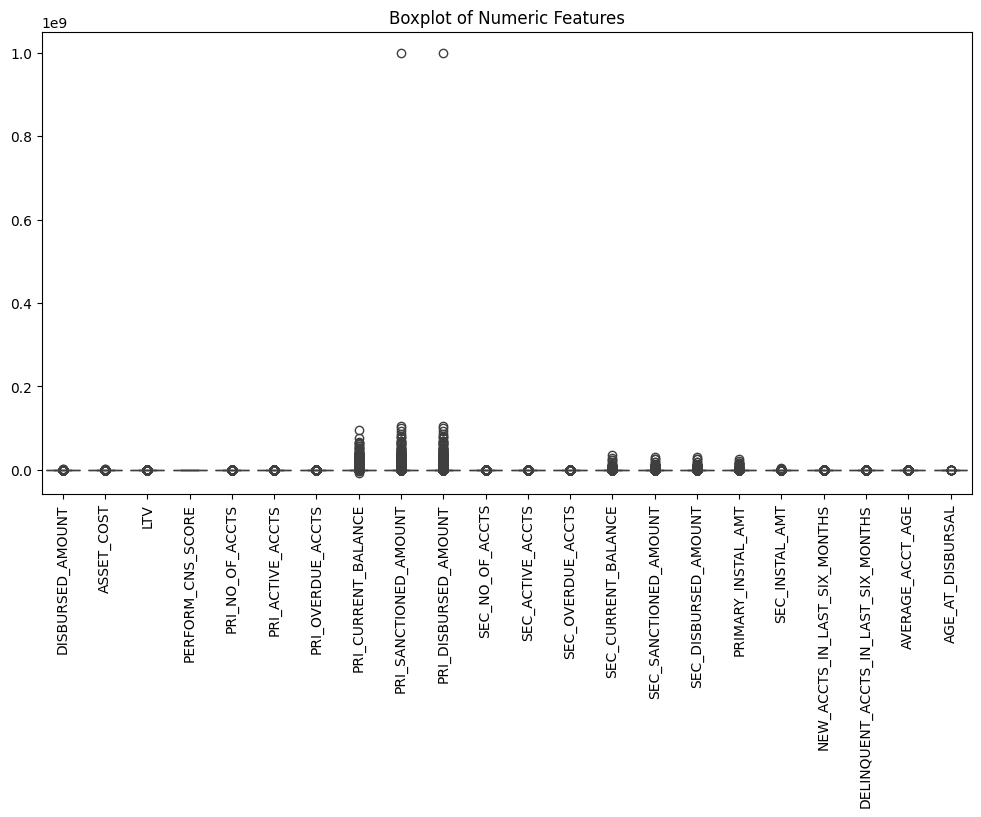

In [105]:
#check for outliers
numeric_cols=['DISBURSED_AMOUNT','ASSET_COST','LTV','PERFORM_CNS_SCORE','PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
                'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT',
                'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
                'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT',
                'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT',
                'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
                'AVERAGE_ACCT_AGE','AGE_AT_DISBURSAL']
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=90)
plt.title('Boxplot of Numeric Features')
plt.show()

In [106]:
outlier_flags=pd.DataFrame()
for col in numeric_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Create a new column that flags outliers as 1
  outlier_flags[col + '_outlier'] = ((df[col] < lower_bound) | (df[col] > upper_bound)).astype(int)


In [113]:
#outlier_flags.sum().sort_values(ascending=False)

In [101]:
df.columns

Index(['UNIQUEID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID',
       'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'STATE_ID',
       'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG',
       'VOTERID_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE',
       'PERFORM_CNS_SCORE_DESCRIPTION', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
       'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT',
       'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
       'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT',
       'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT',
       'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
       'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES',
       'LOAN_DEFAULT', 'AGE_AT_DISBURSAL', 'EMP_Salaried', 'EMP_Self employed',
       'EMP_unknown'],
      dtype='object')

In [123]:
hmap_cols=['DISBURSED_AMOUNT', 'ASSET_COST', 'LTV','PERFORM_CNS_SCORE',
       'PERFORM_CNS_SCORE_DESCRIPTION', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
       'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT',
       'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
       'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT',
       'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT',
       'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
       'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES',
       'LOAN_DEFAULT']

<Axes: >

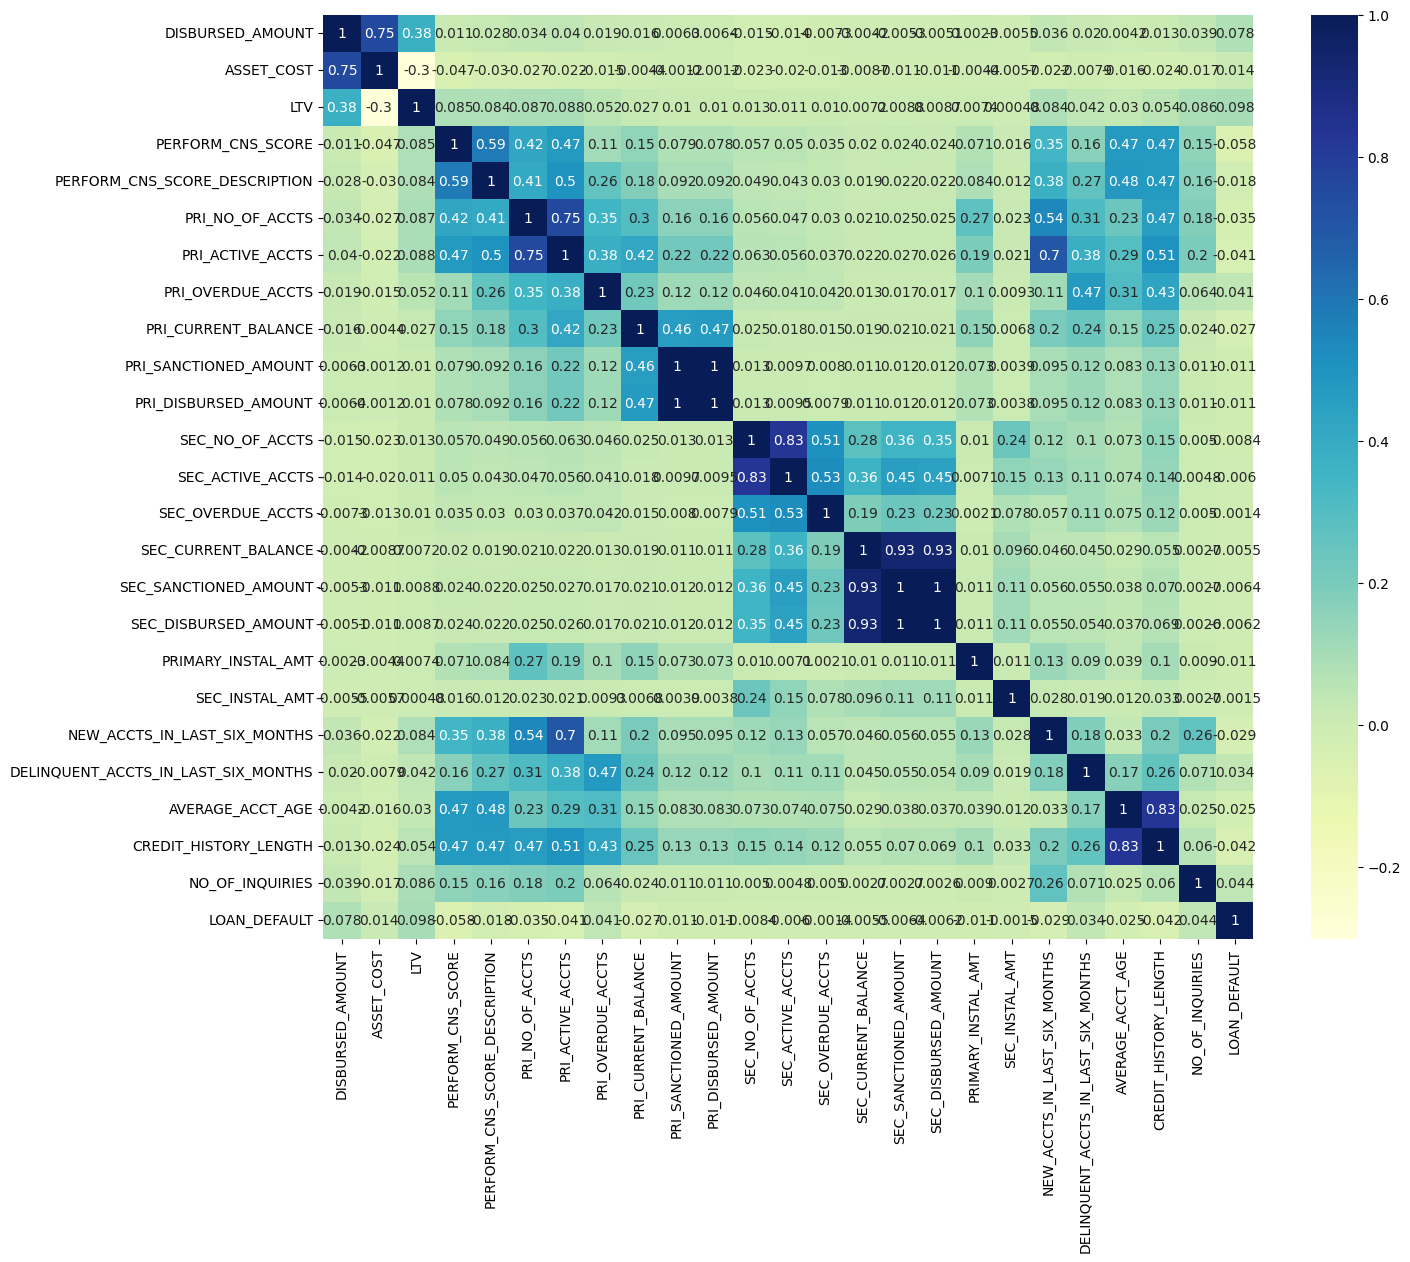

In [124]:
hmap_df=df[hmap_cols]
plt.figure(figsize=(15,12))
sns.heatmap(hmap_df.corr(),annot=True,cmap='YlGnBu')

In [125]:
df.head()

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,MOBILENO_AVL_FLAG,AADHAR_FLAG,PAN_FLAG,VOTERID_FLAG,DRIVING_FLAG,...,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT,AGE_AT_DISBURSAL,EMP_Salaried,EMP_Self employed,EMP_unknown
0,420825,50578,58400,89.55,67,1,1,0,0,0,...,0,0,0,0,0,0,34,1,0,0
1,537409,47145,65550,73.23,67,1,1,0,0,0,...,0,1,695,695,0,1,33,0,1,0
2,417566,53278,61360,89.63,67,1,1,0,0,0,...,0,0,0,0,0,0,32,0,1,0
3,624493,57513,66113,88.48,67,1,1,0,0,0,...,0,0,240,455,1,1,24,0,1,0
4,539055,52378,60300,88.39,67,1,1,0,0,0,...,0,0,0,0,1,1,40,0,1,0


In [126]:
y=df['LOAN_DEFAULT']
X=df.drop('LOAN_DEFAULT',axis=1)

In [129]:
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [130]:
smote=SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [133]:
def plot_confusion_matrix(y_true,y_pred):
  cm=confusion_matrix(y_true,y_pred)
  labels=['no_default 0','default 1']
  sns.heatmap(cm,xticklabels=labels,yticklabels=labels,annot=True,fmt='d')
  plt.title('confusion matrix')
  plt.ylabel("actual label")
  plt.xlabel("predicted label")
  print("True Negative :",cm[0][0])
  print("False Positive :",cm[0][1])
  print("False Negative :",cm[1][0])
  print("True Positive :",cm[1][1])
  print('total :',np.sum(cm[1]))

True Negative : 34163
False Positive : 2346
False Negative : 8919
True Positive : 1203
total : 10122
              precision    recall  f1-score   support

           0       0.79      0.94      0.86     36509
           1       0.34      0.12      0.18     10122

    accuracy                           0.76     46631
   macro avg       0.57      0.53      0.52     46631
weighted avg       0.69      0.76      0.71     46631



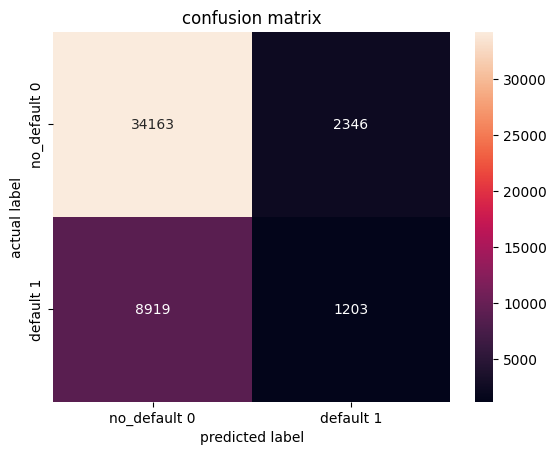

In [135]:
#Random forest classifier
rf_model=RandomForestClassifier(n_estimators=100,random_state=42)
rf_model.fit(X_train_resampled,y_train_resampled)
rf_pred=rf_model.predict(X_test)
plot_confusion_matrix(y_test,rf_pred)
print(classification_report(y_test,rf_pred))


True Negative : 22194
False Positive : 14315
False Negative : 3929
True Positive : 6193
total : 10122
              precision    recall  f1-score   support

           0       0.85      0.61      0.71     36509
           1       0.30      0.61      0.40     10122

    accuracy                           0.61     46631
   macro avg       0.58      0.61      0.56     46631
weighted avg       0.73      0.61      0.64     46631



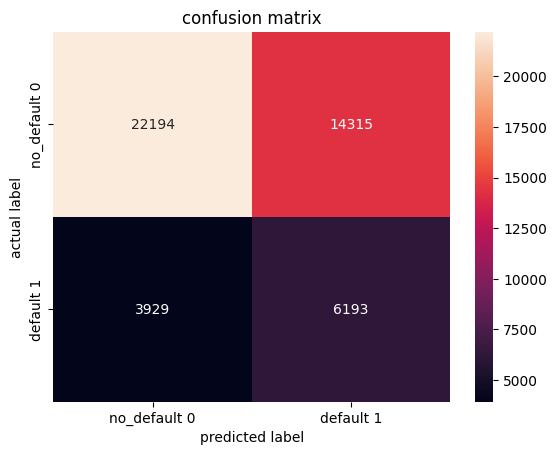

In [136]:
#train xgboost
neg,pos=y_train.value_counts()
scale=neg/pos
xgb_model=xgb.XGBClassifier(scale_pos_weight=scale,random_state=42)
xgb_model.fit(X_train,y_train)
xgb_pred=xgb_model.predict(X_test)
plot_confusion_matrix(y_test,xgb_pred)
print(classification_report(y_test,xgb_pred))